# Deconvolution performance on the ductal carcinoma dataset (Fig 2b,c)

In [1]:
import warnings
import os
import itertools
import torch
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
from plotnine import *

In [3]:
pal = ['#E64B35', '#4DBBD5', '#00A087', #'#3C5488', 
       '#F39B7F', '#8491B4', '#91D1C2', '#DC0000', '#7E6148', '#B09C85']
from plotnine.scales.scale_discrete import scale_discrete
class scale_fill_npg(scale_discrete):
    """GGSCI-NPG fill scale
    Args:
        palette: The fill palette name
    """

    _aesthetics = ["fill"]
    na_value = "#7F7F7F"

    def __init__(self, palette="colors", **kwargs):
        """Construct"""
        self.palette = lambda n: pal[:n]
        scale_discrete.__init__(self, **kwargs)

class scale_color_npg(scale_discrete):
    """GGSCI-NPG color scale
    Args:
        palette: The color palette name
    """

    _aesthetics = ["color"]
    na_value = "#7F7F7F"

    def __init__(self, palette="colors", **kwargs):
        """Construct"""
        self.palette = lambda n: pal[:n]
        scale_discrete.__init__(self, **kwargs)

## Load the ST data

In [4]:
# data_dir = "/Users/jysumac/Projects/SpatialDeconv/results/if_analysis/"
# fig_res_dir = "/Users/jysumac/Projects/SpatialDeconv/results/figures/"
data_dir = "/Users/jfr2137/Desktop/Research/Rabadan Lab/Spatial Deconvolution/Data/ductal_carcinoma/10x_visium/"
res_dir = "/Users/jfr2137/Desktop/Research/Rabadan Lab/Spatial Deconvolution/Results/ductal_carcinoma/"
fig_res_dir = "/Users/jfr2137/Desktop/Research/Rabadan Lab/Spatial Deconvolution/Figures/"

In [7]:
def read_sp_data(data_dir, sample_id):
    from matplotlib.image import imread
    import json
    count_dir = data_dir + "filtered_count_matrix/"
    sp_dir = data_dir + "spatial/"
    meta_dir = data_dir + "metadata.csv"
    
    # load counts
    adata = sc.read_10x_mtx(count_dir)
    
    # load spatial data
    adata.uns["spatial"] = dict()
    adata.uns["spatial"][sample_id] = dict()

    files = dict(
        tissue_positions_file = sp_dir + '/tissue_positions_list.csv',
        scalefactors_json_file = sp_dir + '/scalefactors_json.json',
        hires_image = sp_dir + '/tissue_hires_image.png',
        lowres_image = sp_dir  + '/tissue_lowres_image.png',
    )

    adata.uns["spatial"][sample_id]['images'] = dict()

    for res in ['hires', 'lowres']:
        try:
            adata.uns["spatial"][sample_id]['images'][res] = imread(
                str(files[f'{res}_image'])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")

    # read json scalefactors
    with open(files['scalefactors_json_file']) as f:
        js = json.load(f)
    adata.uns["spatial"][sample_id]['scalefactors'] = js

    # read coordinates
    positions = pd.read_csv(files['tissue_positions_file'], header=None)
    positions.columns = [
        'barcode',
        'in_tissue',
        'array_row',
        'array_col',
        'pxl_col_in_fullres',
        'pxl_row_in_fullres',
    ]
    positions.index = positions['barcode']

    adata.obs = adata.obs.join(positions, how="left")

    adata.obsm['spatial'] = adata.obs[
        ['pxl_row_in_fullres', 'pxl_col_in_fullres']
    ].to_numpy()
    adata.obs.drop(
        columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
        inplace=True,
    )
    
    # load meta
    meta = pd.read_csv(meta_dir, header=0, sep=',', index_col=0)
    adata.obs = adata.obs.join(meta, how="left")
    
    return adata

In [8]:
sample_id = "ductal_carcinoma"
st = read_sp_data(data_dir, sample_id)

# remove the following two spots
st = st[~st.obs_names.isin(['AGAAGAGCGCCGTTCC-1', 'TCGCGTAGCAGTGTCC-1']),:]

# st.obsm['spatial'] = st.obs[['imagecol', 'imagerow']].values
st.obsm['spatial'][:,1] = - st.obsm['spatial'][:,1]

/var/folders/m9/hd75_cj57fjbfjrz4ftnxgbh0000gp/T/ipykernel_89226/4083437371.py:8: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.


### Load metadata

In [9]:
st_meta = pd.read_csv(data_dir + "ifdata.csv", index_col=0)
st.obs = st.obs.join(st_meta, how='left')

### Load deconv results

In [10]:
methods = ['NNLS', 'DWLS', 'NuSVR', 'CARD']
sp_losses = ['no_spatial', 'raw']

for m, sp_loss in itertools.product(methods, sp_losses):
    res = pd.read_csv(f"{res_dir}deconv_results/ductal_carcinoma_{sp_loss}_{m}.csv", index_col='voxel')
    res.columns = res.columns.str.replace('.', '-')
    st.obs[f'T_prop_{m}_{sp_loss}'] = res.loc[st.obs.index,'T-cells']

### Check CD3 expressions

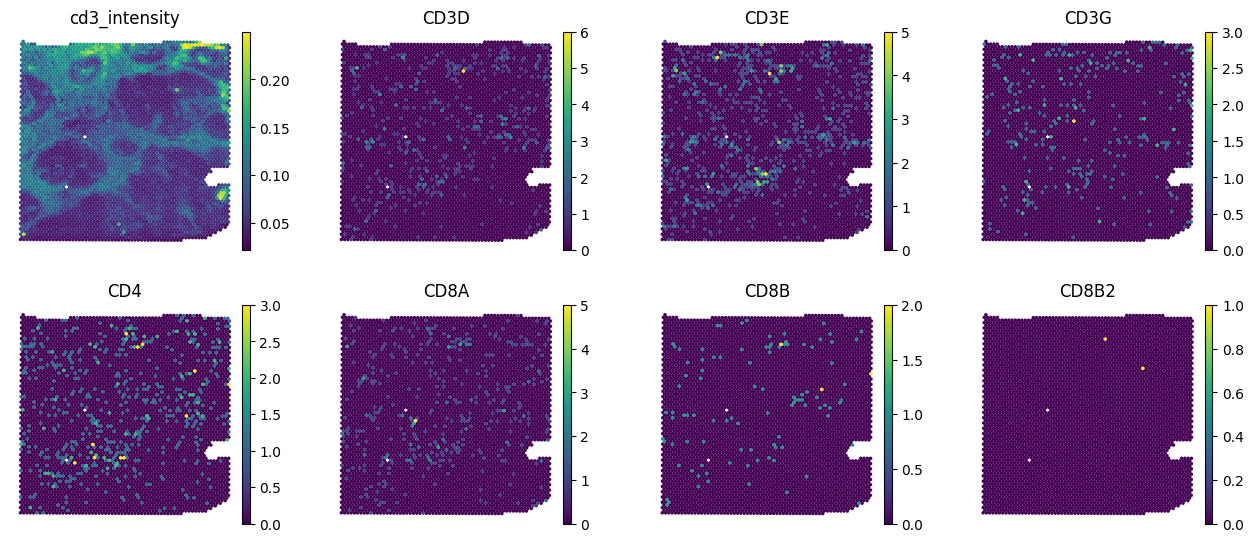

In [11]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(st, basis='spatial', frameon=False,
                    color=['cd3_intensity', 'CD3D', 'CD3E', 'CD3G', 'CD4', 'CD8A', 'CD8B', 'CD8B2'])

## Cell-type proportion pie chart

In [12]:
st

AnnData object with n_obs × n_vars = 4725 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Classification', 'x', 'y', 'cd3_intensity', 'dapi_intensity', 'count', 'annotation', 'T_prop_NNLS_no_spatial', 'T_prop_NNLS_raw', 'T_prop_DWLS_no_spatial', 'T_prop_DWLS_raw', 'T_prop_NuSVR_no_spatial', 'T_prop_NuSVR_raw', 'T_prop_CARD_no_spatial', 'T_prop_CARD_raw'
    var: 'gene_ids', 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'

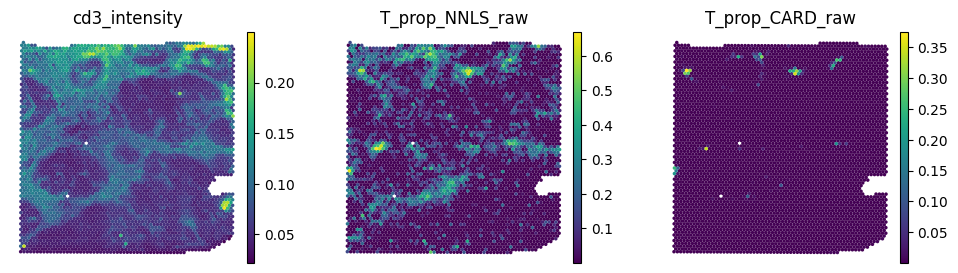

In [13]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(
        st, basis='spatial', frameon=False,
        color=['cd3_intensity', 'T_prop_NNLS_raw', 'T_prop_CARD_raw'], 
        return_fig=True, show=False)

plt.savefig(fig_res_dir + '/if/fig2a.pdf')
plt.show()

## Correlation between CD3 intensities and T-cell abundances

In [14]:
def pearsonr_ci(x, y, alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = sp.stats.pearsonr(x, y)
    r_z = np.arctanh(r)
    se = 1 / np.sqrt(x.size - 3)
    z = sp.stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def spearmanr_ci(x, y, alpha = 0.05):
    ''' Spearman R and the confidence interval using Bonnett and Wright (2000)
    https://stats.stackexchange.com/questions/18887/how-to-calculate-a-confidence-interval-for-spearmans-rank-correlation
    '''
    r, p = sp.stats.spearmanr(x, y)
    r_z = np.arctanh(r)
    se = np.sqrt((1 + r**2 / 2)/(x.size - 3))
    z = sp.stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

### Correlation with the estimated T cell proportion

In [15]:
corr_metric = 'spearman'
assert corr_metric in ['pearson', 'spearman']
if corr_metric == 'pearson':
    corr_func = pearsonr_ci
else:
    corr_func = spearmanr_ci

corr_df = []
methods = ['NNLS', 'DWLS', 'NuSVR', 'CARD']
sp_losses = ['no_spatial', 'raw']

for m, sp_loss in itertools.product(methods, sp_losses):
    corr = corr_func(st.obs[f'T_prop_{m}_{sp_loss}'], st.obs['cd3_intensity'], alpha = 0.05)
    _df = pd.DataFrame(
        {'corr': corr[0],
         'lo': corr[2], 'hi': corr[3],
         'deconv_model': m, 'spatial_loss': sp_loss == 'raw'
        }, index=[0])
    _df['model'] = f"{m}_{sp_loss}"
    _df['spatial_loss_cat'] = pd.Categorical(_df.spatial_loss, [True, False])
    corr_df.append(_df)

corr_df = pd.concat(corr_df)
corr_df['deconv_model'] = corr_df['deconv_model'].str.replace('NuSVR', 'SVR')
corr_df['deconv_model'] = pd.Categorical(corr_df.deconv_model, ['NNLS', 'DWLS', 'SVR','CARD'])
corr_df

,corr,lo,hi,deconv_model,spatial_loss,model,spatial_loss_cat
0,0.262505,0.235295,0.289304,NNLS,False,NNLS_no_spatial,False
0,0.368863,0.343124,0.394048,NNLS,True,NNLS_raw,True
0,0.297667,0.270877,0.323996,DWLS,False,DWLS_no_spatial,False
0,0.312951,0.286364,0.339056,DWLS,True,DWLS_raw,True
0,0.127710,0.099443,0.155771,SVR,False,NuSVR_no_spatial,False
0,0.434208,0.409687,0.458103,SVR,True,NuSVR_raw,True
0,0.238454,0.210992,0.265540,CARD,False,CARD_no_spatial,False
0,0.240627,0.213187,0.267688,CARD,True,CARD_raw,True


#### Correlation with T cell markers

In [16]:
genes = ['CD3D', 'CD3E', 'CD3G', 'CD4', 'CD8A', 'CD8B', 'CD8B2']

corr_df_gene = []
for g in genes:
    corr = corr_func(st[:, g].X.toarray(), st.obs['cd3_intensity'], alpha = 0.05)
    _df = pd.DataFrame(
        {'corr': corr[0],
         'lo': corr[2], 'hi': corr[3],
         'gene': g
        }, index=[0])
    corr_df_gene.append(_df)

corr_df_gene = pd.concat(corr_df_gene)
corr_df_gene = corr_df_gene.sort_values('corr', ascending=False)
corr_df_gene['gene'] = pd.Categorical(
    corr_df_gene['gene'],
    categories=corr_df_gene['gene'], ordered=True
)
corr_df_gene

,corr,lo,hi,gene
0,0.235886,0.208399,0.263001,CD3E
0,0.144986,0.116808,0.172932,CD3D
0,0.140205,0.112001,0.168184,CD3G
0,0.125855,0.097579,0.153928,CD4
0,0.092467,0.064061,0.120724,CD8A
0,0.086695,0.058271,0.114978,CD8B
0,0.006585,-0.021934,0.035094,CD8B2


### Visualization

/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:590: PlotnineWarning: Saving 3 x 2 in image.
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:591: PlotnineWarning: Filename: /Users/jfr2137/Desktop/Research/Rabadan Lab/Spatial Deconvolution/Figures//if/fig2b1.pdf
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


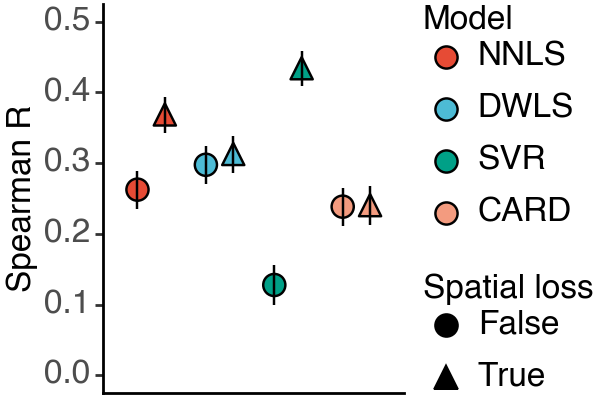

<Figure Size: (300 x 200)>

In [22]:
fontsize = 12

# for visualization
corr_df['x'] = [0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2]

p = (
  ggplot(corr_df, aes(x = 'x', fill = 'deconv_model')) + 
    geom_point(aes(y = 'corr', shape = 'spatial_loss'), 
               size = 4) + 
    geom_linerange(aes(ymin = 'lo', ymax = 'hi',
                       xmin = 'x', xmax = 'x')) + 
    labs(x = '', y = 'Spearman R',
        fill = 'Model', shape = 'Spatial loss') +
    scale_fill_npg() + 
    ylim([0, 0.5]) + 
    xlim([0.5, 4.5]) + 
    theme_classic() +
    theme(
        figure_size = (3, 2), 
        text = element_text(size = fontsize),
        axis_text_x=element_blank(),
        axis_ticks_major_x=element_blank(),
        legend_text=element_text(size = fontsize),
        legend_title=element_text(size = fontsize),
    )
    
)
p.save(fig_res_dir + '/if/fig2b1.pdf')
p

/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:590: PlotnineWarning: Saving 2 x 2.5 in image.
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:591: PlotnineWarning: Filename: /Users/jfr2137/Desktop/Research/Rabadan Lab/Spatial Deconvolution/Figures//if/fig2b2.pdf
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_linerange : Removed 1 rows containing missing values.
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jfr2137/miniconda3/envs

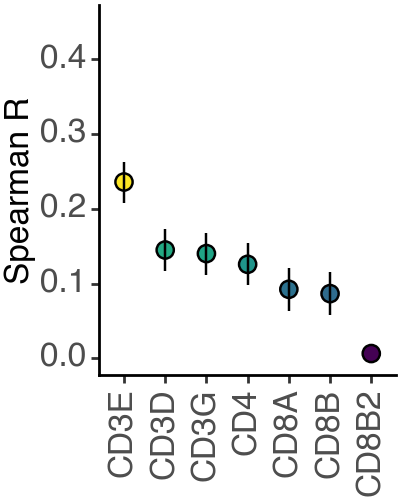

<Figure Size: (200 x 250)>

In [23]:
fontsize = 12

p = (
  ggplot(corr_df_gene, aes(x = 'gene', fill = 'corr')) + 
    geom_point(aes(y = 'corr'), 
               size = 3) + 
    geom_linerange(aes(ymin = 'lo', ymax = 'hi',
                       xmin = 'gene', xmax = 'gene')) + 
    labs(x = '', y = 'Spearman R') +
    ylim([0, 0.45]) + 
    theme_classic() +
    theme(
        figure_size = (2, 2.5), 
        text=element_text(size = fontsize),
        axis_text_x=element_text(rotation=90),
        legend_position='none'
    )
)
p.save(fig_res_dir + '/if/fig2b2.pdf')
p

/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:590: PlotnineWarning: Saving 4 x 4 in image.
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:591: PlotnineWarning: Filename: /Users/jfr2137/Desktop/Research/Rabadan Lab/Spatial Deconvolution/Figures//if/oldfig2a.pdf
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

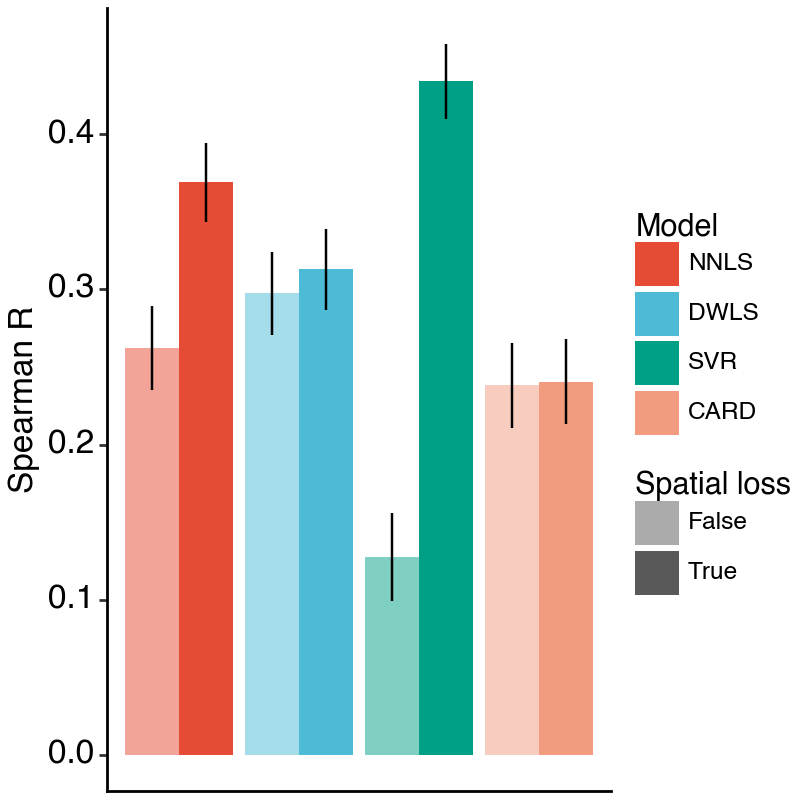

<Figure Size: (400 x 400)>

In [44]:
p1 = (
    ggplot(corr_df, 
          aes(x='deconv_model', y = 'corr', group = 'model')) +
    geom_col(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge") +
    geom_linerange(aes(ymin = 'lo', ymax = 'hi',
                       xmin = 'deconv_model', xmax = 'deconv_model'),
                   position = position_dodge(0.9)) + 
    scale_fill_npg() + 
    scale_alpha_manual([0.5,1]) +
    labs(x = '', y = 'Spearman R',
            fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (4, 4), 
          strip_text_x = element_text(size = fontsize),
          axis_title_y = element_text(size = fontsize),
          axis_text_y = element_text(size = fontsize, color = 'black'),
          axis_text_x=element_blank(),
          axis_ticks_major_x=element_blank())
)

p1.save(fig_res_dir + '/if/oldfig2a.pdf', height=4, width=4)

p1

## Binary prediction accuracy of T-cell presence in the tumor region

### Load deconvolution results and calculate binary accuracy scores

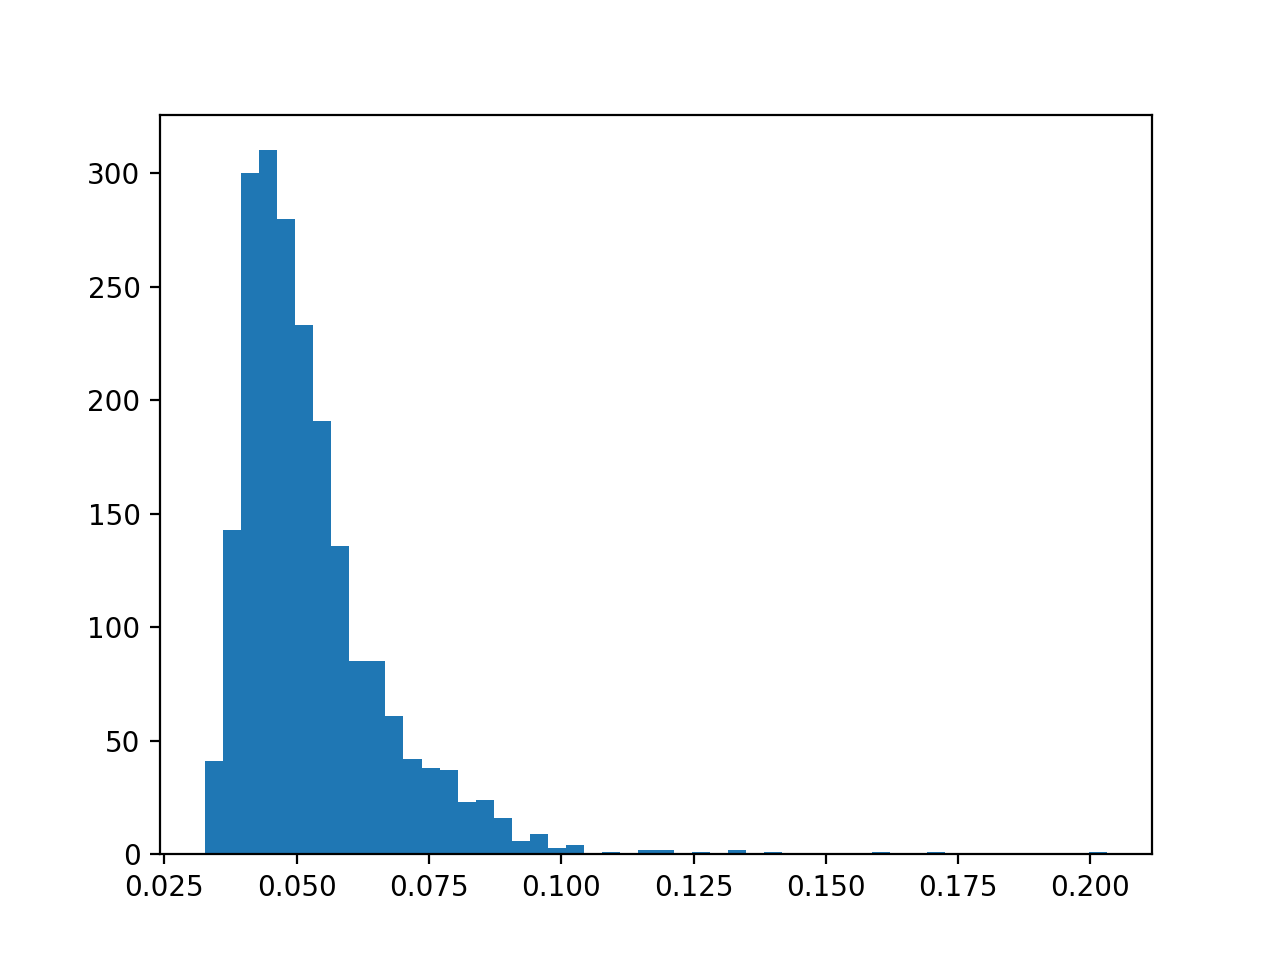

[[0.04767253]
 [0.06972904]]
0.062512108 0.18133718133718132


In [35]:
from sklearn.mixture import GaussianMixture as GMM

df_nnls = pd.read_csv(f"{res_dir}deconv_results/ductal_carcinoma_raw_NNLS.csv")
df_nnls = df_nnls.loc[(~pd.isna(df_nnls["count"])) & 
                      (df_nnls["annotation"].isin(("Invasive", "Benign hyperplasia"))), :]
cd3 = df_nnls['cd3_intensity']
cd3 = cd3.to_numpy().reshape(-1, 1)
plt.hist(cd3, bins = 50)
plt.show()

# find the threshold for T-cell presence
# using a 2-component Gaussian mixture model
gmm = GMM(n_components=2).fit(cd3)
print(gmm.means_)

# get prediction boundary
cd3_threshold = (cd3[gmm.predict(cd3) == 1]).min()
print(cd3_threshold, np.mean(cd3 >= cd3_threshold))

In [36]:
from sklearn.metrics import roc_auc_score, average_precision_score

methods = ['NNLS', 'DWLS', 'NuSVR', 'CARD']

accu_metric = 'roc'
assert accu_metric in ['roc', 'pr']
if accu_metric == 'roc':
    accu_func = roc_auc_score
else:
    accu_func = average_precision_score

accu_df = []
for m in methods:
    for sp_loss in ['no_spatial', 'raw']:
        res = pd.read_csv(f"{res_dir}/deconv_results/ductal_carcinoma_{sp_loss}_{m}.csv")
        res = res.loc[(~pd.isna(res["count"])) & 
                      (res["annotation"].isin(("Invasive", "Benign hyperplasia"))), :]
        res.columns = res.columns.str.replace('.', '-')
        accu = accu_func(res['cd3_intensity'] >= cd3_threshold, res['T-cells'])
        _df = pd.DataFrame(
            {'accu': accu,
             'deconv_model': m, 'spatial_loss': sp_loss == 'raw'
            }, index=[0])
        _df['model'] = f"{m}_{sp_loss}"
        _df['spatial_loss_cat'] = pd.Categorical(_df.spatial_loss, [True, False])
        accu_df.append(_df)

accu_df = pd.concat(accu_df)
accu_df['deconv_model'] = accu_df['deconv_model'].str.replace('NuSVR', 'SVR')
accu_df['deconv_model'] = pd.Categorical(accu_df.deconv_model, ['NNLS', 'DWLS', 'SVR','CARD'])
accu_df

,accu,deconv_model,spatial_loss,model,spatial_loss_cat
0,0.564468,NNLS,False,NNLS_no_spatial,False
0,0.595665,NNLS,True,NNLS_raw,True
0,0.598418,DWLS,False,DWLS_no_spatial,False
0,0.591302,DWLS,True,DWLS_raw,True
0,0.506281,SVR,False,NuSVR_no_spatial,False
0,0.534654,SVR,True,NuSVR_raw,True
0,0.546851,CARD,False,CARD_no_spatial,False
0,0.547069,CARD,True,CARD_raw,True


### Visualization

/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:590: PlotnineWarning: Saving 4 x 4 in image.
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/plotnine/ggplot.py:591: PlotnineWarning: Filename: /Users/jfr2137/Desktop/Research/Rabadan Lab/Spatial Deconvolution/Figures//if/oldfig2a.pdf
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

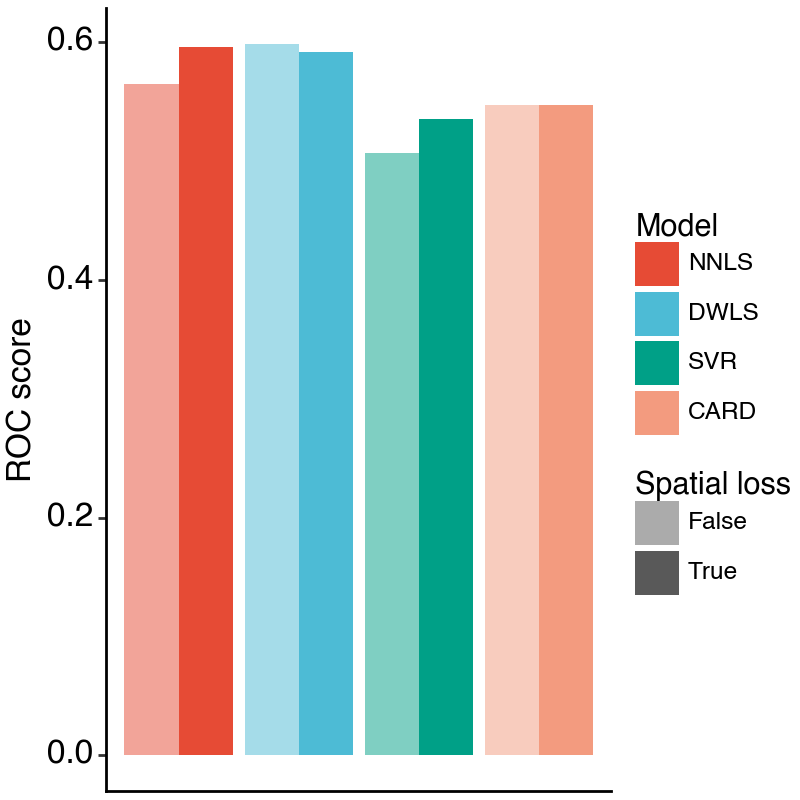

<Figure Size: (400 x 400)>

In [45]:
p2 = (
    ggplot(accu_df, 
          aes(x='deconv_model', y = 'accu', group = 'model')) +
    geom_col(aes(alpha = 'spatial_loss', fill = 'deconv_model'),
                position = "dodge") +
    scale_fill_npg() + 
    scale_alpha_manual([0.5,1]) +
    labs(x = '', y = 'ROC score',
            fill = 'Model', alpha = 'Spatial loss') +
    theme_classic() +
    theme(figure_size = (4, 4), 
          strip_text_x = element_text(size = fontsize),
          axis_title_y = element_text(size = fontsize),
          axis_text_y = element_text(size = fontsize, color = 'black'),
          axis_text_x=element_blank(),
          axis_ticks_major_x=element_blank())
)

p2.save(fig_res_dir + '/if/oldfig2a.pdf', height=4, width=4)
p2

### ROC curve

In [39]:
from sklearn.metrics import roc_curve

methods = ['NNLS', 'DWLS', 'NuSVR', 'CARD']

curve_df = []
for m in methods:
    for sp_loss in ['no_spatial', 'raw']:
        res = pd.read_csv(f"{res_dir}/deconv_results/ductal_carcinoma_{sp_loss}_{m}.csv")
        res = res.loc[(~pd.isna(res["count"])) & 
                      (res["annotation"].isin(("Invasive", "Benign hyperplasia"))), :]
        res.columns = res.columns.str.replace('.', '-')
        fpr, tpr, _ = roc_curve(res['cd3_intensity'] >= cd3_threshold, res['T-cells'])
        _df = pd.DataFrame({'fpr': fpr, 'tpr' : tpr})
        _df['deconv_model'] = m
        _df['spatial_loss'] = sp_loss == 'raw'
        _df['model'] = f"{m}_{sp_loss}"
        _df['spatial_loss_cat'] = pd.Categorical(_df.spatial_loss, [True, False])
        curve_df.append(_df)

curve_df = pd.concat(curve_df)
curve_df['deconv_model'] = curve_df['deconv_model'].str.replace('NuSVR', 'SVR')
curve_df['deconv_model'] = pd.Categorical(curve_df.deconv_model, ['NNLS', 'DWLS', 'SVR','CARD'])

/Users/jfr2137/miniconda3/envs/smoother/lib/python3.10/site-packages/mizani/scale.py:256: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


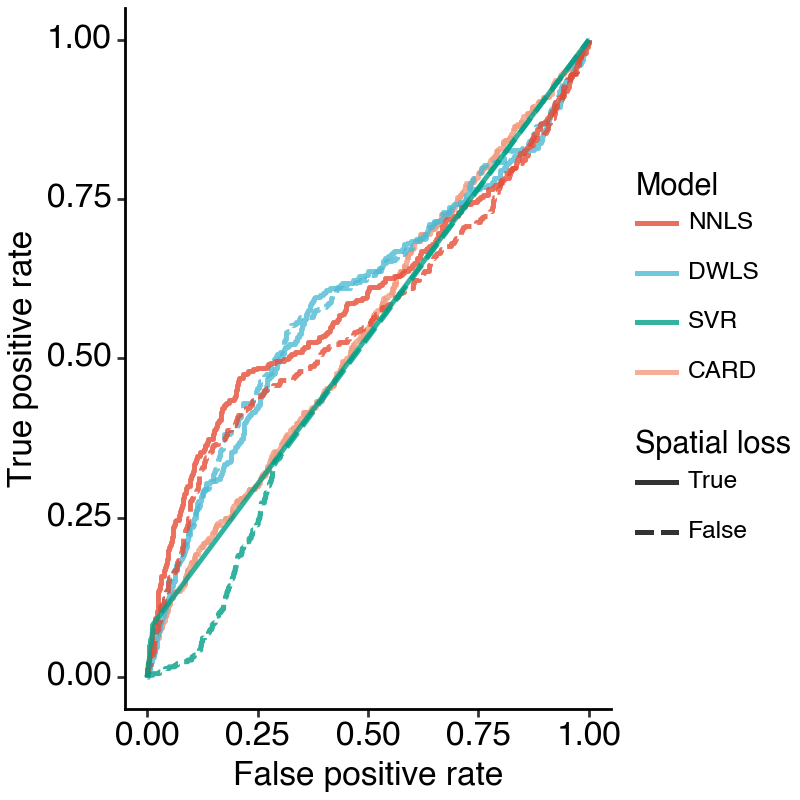

<Figure Size: (400 x 400)>

In [46]:
(
    ggplot(curve_df, 
          aes(x='fpr', y = 'tpr', group = 'model')) +
    geom_line(aes(linetype = 'spatial_loss_cat', color = 'deconv_model'),
              size = 1, alpha = 0.8) +
    labs(x = 'False positive rate', y = 'True positive rate',
         color = 'Model', linetype = 'Spatial loss') +
    scale_color_npg() + 
    theme_classic() +
    theme(figure_size = (4, 4), 
          strip_text_x = element_text(size = fontsize),
          axis_title = element_text(size = fontsize),
          axis_text_y = element_text(size = fontsize, color = 'black'),
          axis_text_x = element_text(size = fontsize, color = 'black'))
)